In [124]:
### Andrew Dant & Alicia Hernandez
### AI 570
### Professor Wang
### Chest X-Ray Project

#Libraries and stuff
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import os

#Upload the CSV file
path = r"C:\Users\andrew.dant\Downloads\archive"
os.chdir(path)
patients = pd.read_csv("Data_Entry_2017.csv")

#Data Exploration
print(patients.head())
print(patients.columns)
print(patients.describe())
print(patients.shape)  #(112120, 12)
print(patients.dtypes)     #object, int64, float64


        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN 

In [125]:
print(patients['Patient Gender'].unique())
# encode patient gender as zero or one
patients['Patient Gender'] = patients['Patient Gender'].map({'M': 0, 'F': 1})

['M' 'F']


In [126]:
print(patients['View Position'].unique())
# encode patient gender as zero or one
patients['View Position'] = patients['View Position'].map({'PA': 0, 'AP': 1})

['PA' 'AP']


In [127]:
# empty/fake column caused by a trailing comma in the CSV file
columns_to_drop = ['Unnamed: 11']
patients = patients.drop(columns=columns_to_drop)

In [128]:

# Clean column names
patients.columns = (
    patients.columns
    .str.lower()               # Convert to lowercase
    .str.replace(' ', '_')     # Replace spaces with underscores
    .str.replace(r'[^a-zA-Z0-9_]', '', regex=True)  # Remove special characters
    .str.strip()               # Strip whitespace
)

print("Cleaned column names:")
print(patients.columns)


Cleaned column names:
Index(['image_index', 'finding_labels', 'followup_', 'patient_id',
       'patient_age', 'patient_gender', 'view_position', 'originalimagewidth',
       'height', 'originalimagepixelspacingx', 'y'],
      dtype='object')


In [129]:
feature_columns = ['patient_age', 'patient_gender', 'view_position']
print(patients[feature_columns].head())

   patient_age  patient_gender  view_position
0           58               0              0
1           58               0              0
2           58               0              0
3           81               0              0
4           81               1              0


In [130]:
# determine the set of unique interests
finding_set = set()
for finding_list in patients['finding_labels'].tolist():
    for finding in finding_list.split('|'):
        finding_set.add(finding)
        
print(f'Unique diagnoses in "finding_labels": {sorted(finding_set)}')

label_columns = [finding for finding in finding_set]

# build the columns and rows of the dummy variables
dummy_finding_variables = []
for finding_list in patients['finding_labels'].tolist():
    dummy_finding_variables.append([1 if finding in finding_list.split('|') else 0 for finding in finding_set])

dummy_finding_variables = pd.DataFrame(dummy_finding_variables, columns=label_columns)

# replace the old finding labels column with the dummy variables
patients.drop('finding_labels', axis=1, inplace=True)
patients = patients.join(dummy_finding_variables)
patients.dtypes

print(patients[label_columns].head())


Unique diagnoses in "finding_labels": ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
   Fibrosis  Pleural_Thickening  Infiltration  Edema  Pneumonia  Hernia  \
0         0                   0             0      0          0       0   
1         0                   0             0      0          0       0   
2         0                   0             0      0          0       0   
3         0                   0             0      0          0       0   
4         0                   0             0      0          0       1   

   No Finding  Nodule  Emphysema  Consolidation  Atelectasis  Effusion  \
0           0       0          0              0            0         0   
1           0       0          1              0            0         0   
2           0       0          0              0            0         1   
3          

In [131]:
patients[label_columns].sum()

Fibrosis               1686
Pleural_Thickening     3385
Infiltration          19894
Edema                  2303
Pneumonia              1431
Hernia                  227
No Finding            60361
Nodule                 6331
Emphysema              2516
Consolidation          4667
Atelectasis           11559
Effusion              13317
Cardiomegaly           2776
Mass                   5782
Pneumothorax           5302
dtype: int64

In [132]:
# Analyze class imbalance 
total_count = len(patients)
print(f"Number of items: {total_count}")
for label in label_columns:
    true_positive_count = patients[label].sum()
    print(f"{label:<20}: {true_positive_count/total_count:.4f} % positive")

Number of items: 112120
Fibrosis            : 0.0150 % positive
Pleural_Thickening  : 0.0302 % positive
Infiltration        : 0.1774 % positive
Edema               : 0.0205 % positive
Pneumonia           : 0.0128 % positive
Hernia              : 0.0020 % positive
No Finding          : 0.5384 % positive
Nodule              : 0.0565 % positive
Emphysema           : 0.0224 % positive
Consolidation       : 0.0416 % positive
Atelectasis         : 0.1031 % positive
Effusion            : 0.1188 % positive
Cardiomegaly        : 0.0248 % positive
Mass                : 0.0516 % positive
Pneumothorax        : 0.0473 % positive


In [133]:
# Compute class weights to help address class imbalance

class_counts = np.sum(patients[label_columns], axis=0)

class_weights = total_count / (len(class_counts) * class_counts)

class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print(class_weight_dict)

{0: 4.4333728746540135, 1: 2.2081733136386017, 2: 0.3757246741060956, 3: 3.2456216529164856, 4: 5.2233869089215, 5: 32.928046989721, 6: 0.12383271759358969, 7: 1.180645500974043, 8: 2.9708532061473236, 9: 1.6015998857224485, 10: 0.6466534013899703, 11: 0.5612875772821707, 12: 2.692603266090298, 13: 1.2927476075175832, 14: 1.409782472023136}


In [134]:

#Remove NA's
patients.isnull()   #Find missing values in data set
patients = patients.dropna()    #Drop Null values and update df

patients.describe()


,followup_,patient_id,patient_age,patient_gender,view_position,originalimagewidth,height,originalimagepixelspacingx,y,Fibrosis,...,Hernia,No Finding,Nodule,Emphysema,Consolidation,Atelectasis,Effusion,Cardiomegaly,Mass,Pneumothorax
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,...,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463,0.435070,0.399661,2646.078844,2486.438842,0.155649,0.155649,0.015037,...,0.002025,0.538361,0.056466,0.022440,0.041625,0.103095,0.118775,0.024759,0.051570,0.047289
std,15.406320,8403.876972,16.839923,0.495768,0.489831,341.246429,401.268227,0.016174,0.016174,0.121702,...,0.044950,0.498529,0.230821,0.148111,0.199732,0.304084,0.323524,0.155391,0.221158,0.212256
min,0.000000,1.000000,1.000000,0.000000,0.000000,1143.000000,966.000000,0.115000,0.115000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7310.750000,35.000000,0.000000,0.000000,2500.000000,2048.000000,0.143000,0.143000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,13993.000000,49.000000,0.000000,0.000000,2518.000000,2544.000000,0.143000,0.143000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,20673.000000,59.000000,1.000000,1.000000,2992.000000,2991.000000,0.168000,0.168000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,183.000000,30805.000000,414.000000,1.000000,1.000000,3827.000000,4715.000000,0.198800,0.198800,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [135]:

#Find duplicate values
patients.duplicated().sum()     #No duplicates


0

In [136]:

patients[feature_columns]


,patient_age,patient_gender,view_position
0,58,0,0
1,58,0,0
2,58,0,0
3,81,0,0
4,81,1,0
...,...,...,...
112115,39,0,0
112116,29,0,0
112117,42,1,0
112118,30,1,0


In [137]:
#Correlation
# feature columns with a numeric datatype
numeric_features_patients = patients[feature_columns].select_dtypes(include=[np.number])
if not numeric_features_patients.empty:
    print(numeric_features_patients.corr())
else:
    print("No numeric columns to compute correlation.")     #No numeric columns to compute correlation.


                patient_age  patient_gender  view_position
patient_age        1.000000       -0.019823      -0.032861
patient_gender    -0.019823        1.000000      -0.032411
view_position     -0.032861       -0.032411       1.000000


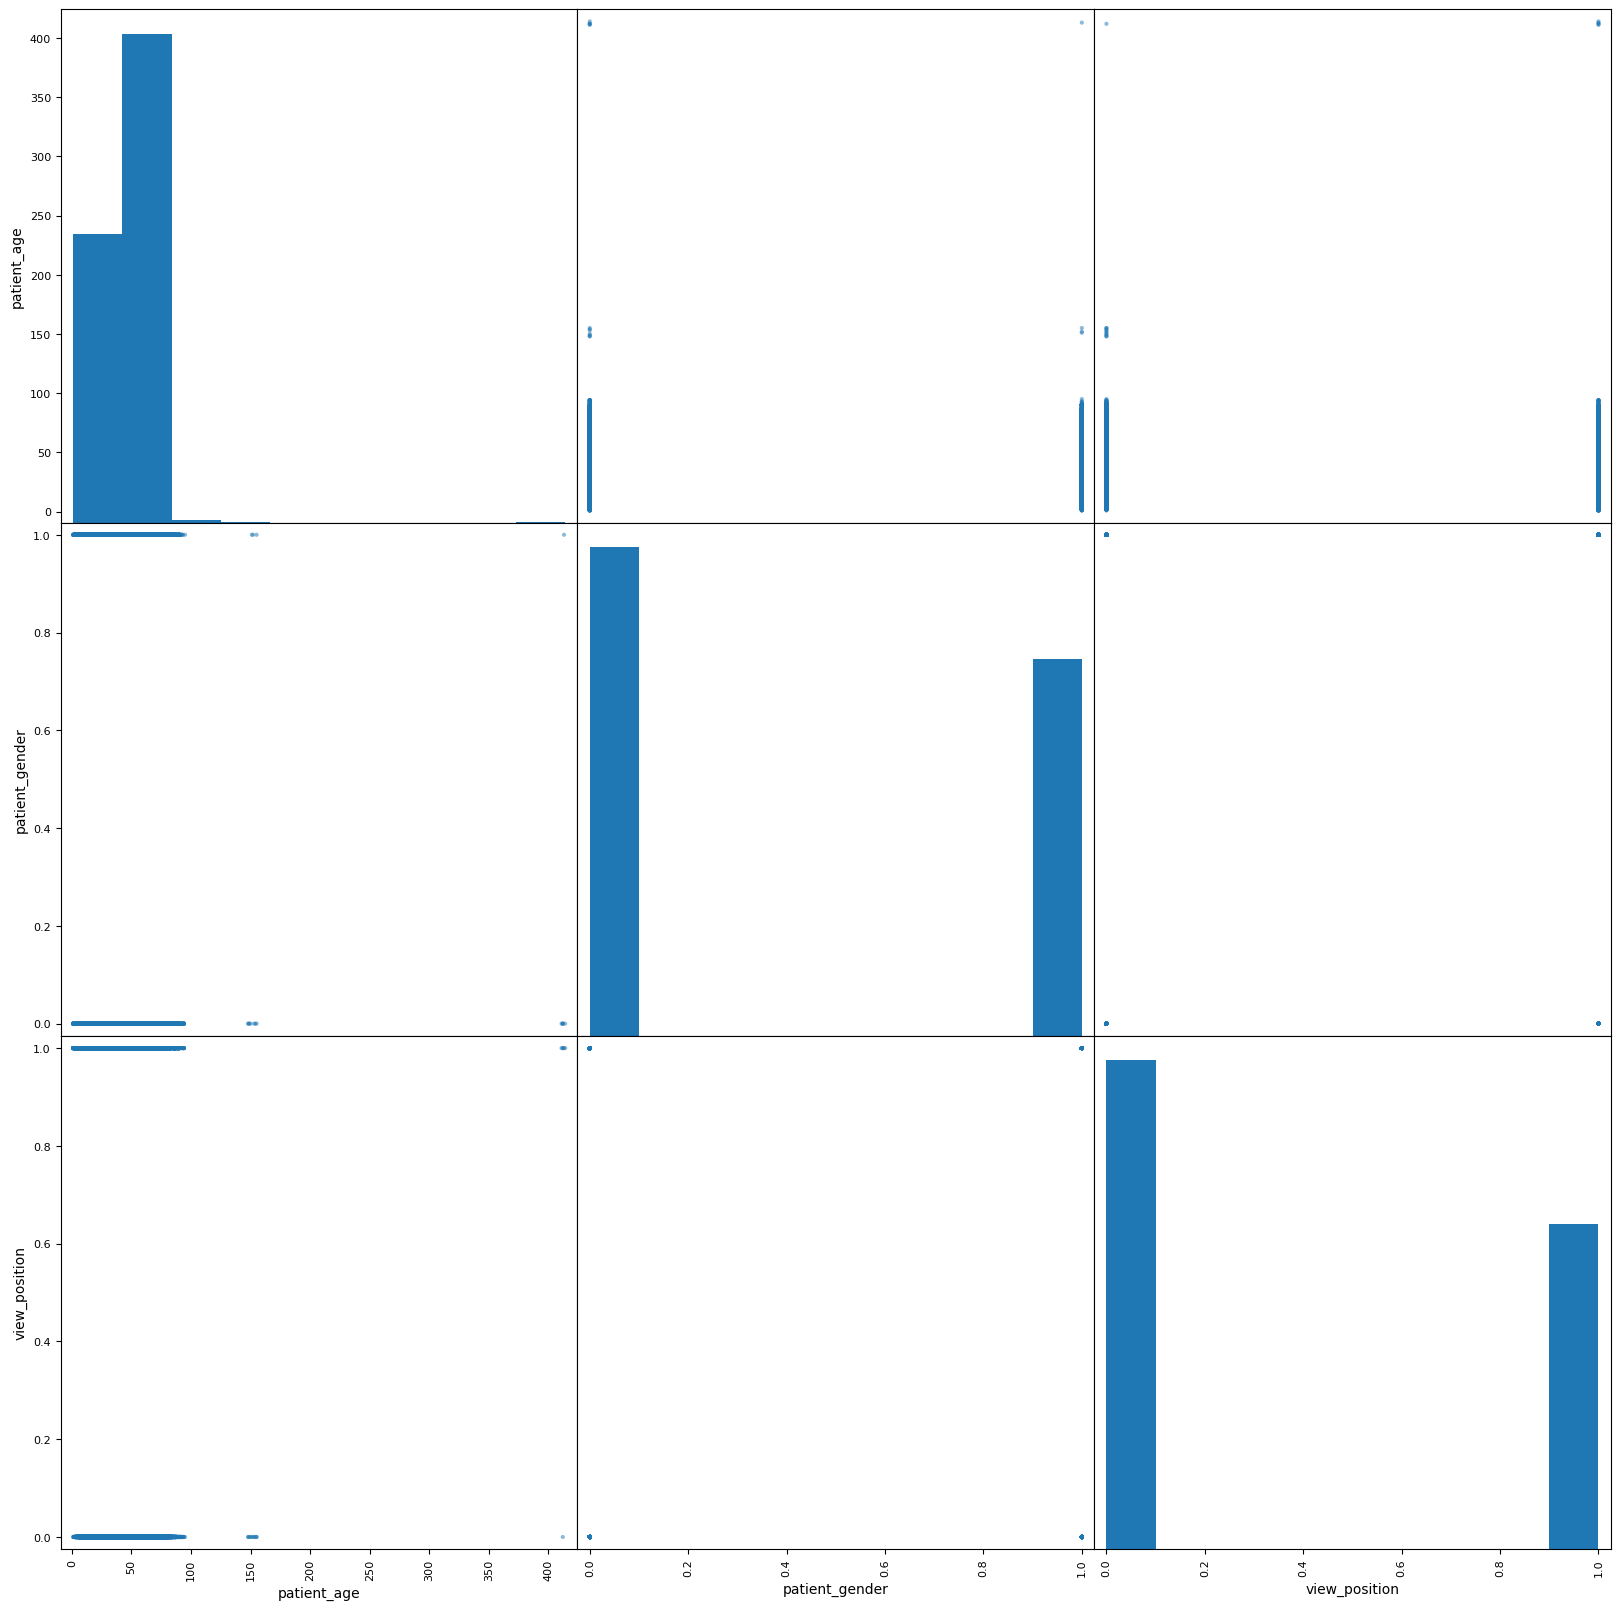

In [138]:

#Scatterplot matrix
if not numeric_features_patients.empty and not numeric_features_patients.isnull().all(axis=0).any():
    pd.plotting.scatter_matrix(numeric_features_patients, figsize=(20, 20))
    plt.show()
else:
    print("No valid numeric data available for scatter matrix.")    #No valid numeric data available for scatter matrix.


In [139]:
patients['patient_age'].describe()

count    112120.000000
mean         46.901463
std          16.839923
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max         414.000000
Name: patient_age, dtype: float64

In [140]:
# maximum patient age does not make sense, most likely bad data since values were obtained via text mining
# clipping the maximum age at 120 years
patients['patient_age'] = patients['patient_age'].clip(upper=120)
patients['patient_age'].describe()

count    112120.000000
mean         46.883009
std          16.619939
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max         120.000000
Name: patient_age, dtype: float64

In [141]:
#Scale the data
scaler = MinMaxScaler()
patients[numeric_features_patients.columns] = scaler.fit_transform(patients[numeric_features_patients.columns])

In [142]:
patients.head()

,image_index,followup_,patient_id,patient_age,patient_gender,view_position,originalimagewidth,height,originalimagepixelspacingx,y,...,Hernia,No Finding,Nodule,Emphysema,Consolidation,Atelectasis,Effusion,Cardiomegaly,Mass,Pneumothorax
0,00000001_000.png,0,1,0.478992,0.0,0.0,2682,2749,0.143,0.143,...,0,0,0,0,0,0,0,1,0,0
1,00000001_001.png,1,1,0.478992,0.0,0.0,2894,2729,0.143,0.143,...,0,0,0,1,0,0,0,1,0,0
2,00000001_002.png,2,1,0.478992,0.0,0.0,2500,2048,0.168,0.168,...,0,0,0,0,0,0,1,1,0,0
3,00000002_000.png,0,2,0.672269,0.0,0.0,2500,2048,0.171,0.171,...,0,1,0,0,0,0,0,0,0,0
4,00000003_000.png,0,3,0.672269,1.0,0.0,2582,2991,0.143,0.143,...,1,0,0,0,0,0,0,0,0,0


In [143]:
file_names = []
for root, dirs, files in os.walk(path):
    file_names.extend([filename for filename in files if '.png' in filename])
    
print(len(file_names))  # the number of image files should match the number of rows in patients

112120


In [144]:
# Filter the DataFrame for existing images
patients_with_images = patients[patients['image_index'].isin(file_names)]

print(patients_with_images.describe())


           followup_     patient_id    patient_age  patient_gender  \
count  112120.000000  112120.000000  112120.000000   112120.000000   
mean        8.573751   14346.381743       0.385572        0.435070   
std        15.406320    8403.876972       0.139663        0.495768   
min         0.000000       1.000000       0.000000        0.000000   
25%         0.000000    7310.750000       0.285714        0.000000   
50%         3.000000   13993.000000       0.403361        0.000000   
75%        10.000000   20673.000000       0.487395        1.000000   
max       183.000000   30805.000000       1.000000        1.000000   

       view_position  originalimagewidth         height  \
count  112120.000000       112120.000000  112120.000000   
mean        0.399661         2646.078844    2486.438842   
std         0.489831          341.246429     401.268227   
min         0.000000         1143.000000     966.000000   
25%         0.000000         2500.000000    2048.000000   
50%         0.0

In [145]:
batch_size = 32

# Loads images from all subdirectories
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=path,
    labels=None,
    image_size=(224, 224),  # all images are resized to this size. Should match model's expectations
    batch_size=None
)

Found 112120 files belonging to 1 classes.


In [146]:
# Map image filenames to row data in patients. Reindex patients to match image order (this will throw an error if there are any image files without an associated row)
reindexed_patients = patients.set_index("image_index")
image_mapped_patients = reindexed_patients.loc[[path.split("\\")[-1] for path in image_dataset.file_paths]]
dataset_length = len(image_mapped_patients)


In [147]:

# Convert feature and label data to TensorFlow datasets
features_dataset = tf.data.Dataset.from_tensor_slices(image_mapped_patients[feature_columns].values)
labels_dataset = tf.data.Dataset.from_tensor_slices(image_mapped_patients[label_columns].values)

combined_dataset = tf.data.Dataset.zip(((image_dataset, features_dataset), labels_dataset))

In [148]:
# randomize the order of the dataset so we are not splitting the sets based on which folder the images are in
combined_dataset = combined_dataset.shuffle(buffer_size=1000, seed=1)

# Split into train and test sets (may add validation in the future)
train_size = int(0.7 * dataset_length)
test_size = dataset_length - train_size

train_dataset = combined_dataset.take(train_size)
test_dataset = combined_dataset.skip(test_size)

train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [149]:
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [150]:
from keras.applications.resnet import ResNet50, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Concatenate, Dropout
from keras.optimizers import Adam

# Load the ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
image_input = base_model.input

# Freeze the layers of ResNet50 so that they are not trainable
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)  # Flatten the output for merging with the numerical path

# Define the numerical input path
patient_input = tf.keras.Input(shape=(len(feature_columns),), name="patient_input")
y = Dense(8, activation="relu")(patient_input)

# Concatenate the outputs from the two paths
combined = Concatenate()([x, y])

# Fully connected layers for the merged path
z = Dense(64, activation="relu")(combined)
z = Dropout(0.3)(z)
z = Dense(32, activation="relu")(z)

# Final output layer for multi-label classification
num_labels = len(label_columns)
output = Dense(num_labels, activation="sigmoid")(z)  # Sigmoid for multi-label binary classification

# Define the model with both inputs and the single output
model = tf.keras.Model(inputs=[image_input, patient_input], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

# Display model architecture
print(model.summary())


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [151]:
# from keras.utils import plot_model
# plot_model(model, to_file='xray_model.png')

In [ ]:
import os

# Path to save/load model
base_model_path = "ResNet50_base.h5"

if os.path.exists(base_model_path):
    print("Loading saved model...")
    
    # TODO should we skip the steps to build the model in this case?
    model = tf.keras.models.load_model(base_model_path)
else:
    print("No saved model found. Training new model...")

    history = model.fit(
        train_dataset,
        epochs=10,
        class_weight=class_weight_dict
    )

    # Save the trained weights
    print("Saving model weights...")
    model.save(base_model_path)


No saved model found. Training new model...
Epoch 1/10
  74/2453 [..............................] - ETA: 33:34 - loss: 0.3075 - accuracy: 0.0608

In [ ]:
# Get predictions on the test set
predictions = model.predict(test_dataset)

2453/2453 [==============================] - 1978s 780ms/step


In [ ]:
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

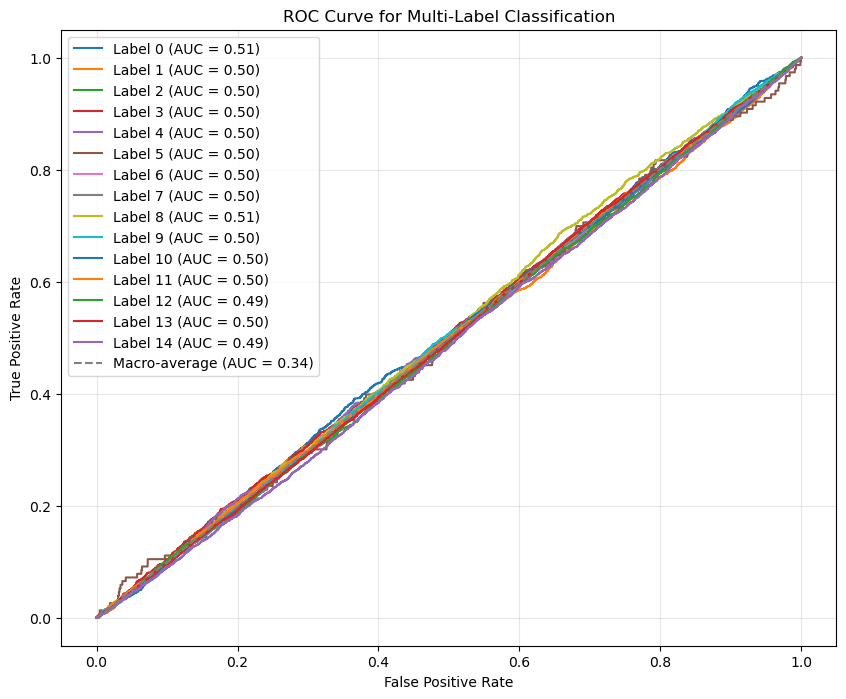

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Number of labels
num_labels = y_true.shape[1]

# Initialize figure for ROC curves
plt.figure(figsize=(10, 8))

# Compute ROC curve and AUC for each label
for i in range(num_labels):
    fpr, tpr, _ = roc_curve(y_true[:, i], predictions[:, i])
    auc = roc_auc_score(y_true[:, i], predictions[:, i])
    plt.plot(fpr, tpr, label=f'Label {i} (AUC = {auc:.2f})')

# Macro-average ROC curve
all_fpr = np.unique(np.concatenate([roc_curve(y_true[:, i], predictions[:, i])[0] for i in range(num_labels)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_labels):
    fpr, tpr, _ = roc_curve(y_true[:, i], predictions[:, i])
    mean_tpr += np.interp(all_fpr, fpr, tpr)
mean_tpr /= num_labels
macro_auc = roc_auc_score(y_true.ravel(), predictions.ravel())
plt.plot(all_fpr, mean_tpr, linestyle='--', color='gray', label=f'Macro-average (AUC = {macro_auc:.2f})')

# Finalize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Label Classification')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.show()


In [ ]:
binary_predictions = (predictions > 0.2).astype(int)

In [ ]:
# Generate a classification report
print(classification_report(y_true, binary_predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1177
           1       0.00      0.00      0.00      2392
           2       0.00      0.00      0.00     14013
           3       0.02      0.40      0.04      1638
           4       0.00      0.00      0.00      1013
           5       0.00      0.00      0.00       153
           6       0.00      0.00      0.00     42186
           7       0.00      0.00      0.00      4413
           8       0.02      1.00      0.04      1771
           9       0.00      0.00      0.00      3279
          10       0.00      0.00      0.00      8090
          11       0.00      0.00      0.00      9371
          12       0.00      0.00      0.00      1921
          13       0.00      0.00      0.00      4051
          14       0.06      0.00      0.00      3756

   micro avg       0.02      0.02      0.02     99224
   macro avg       0.01      0.09      0.01     99224
weighted avg       0.00   

c:\Users\andrew.dant\AppData\Local\anaconda3\envs\AI-570\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
for i, confusion_matrix in enumerate(multilabel_confusion_matrix(y_true, binary_predictions)):
    print(label_columns[i])
    print(confusion_matrix)

Fibrosis
[[77307     0]
 [ 1177     0]]
Pleural_Thickening
[[76092     0]
 [ 2392     0]]
Infiltration
[[64471     0]
 [14013     0]]
Edema
[[46184 30662]
 [  985   653]]
Pneumonia
[[77470     1]
 [ 1013     0]]
Hernia
[[78331     0]
 [  153     0]]
No Finding
[[36298     0]
 [42186     0]]
Nodule
[[74071     0]
 [ 4413     0]]
Emphysema
[[    0 76713]
 [    0  1771]]
Consolidation
[[75205     0]
 [ 3279     0]]
Atelectasis
[[70394     0]
 [ 8090     0]]
Effusion
[[69113     0]
 [ 9371     0]]
Cardiomegaly
[[76563     0]
 [ 1921     0]]
Mass
[[74433     0]
 [ 4051     0]]
Pneumothorax
[[74696    32]
 [ 3754     2]]


NameError: name 'history' is not defined

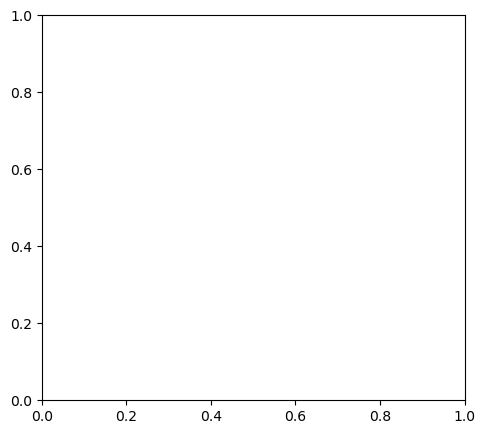

In [ ]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()